In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap


In [2]:
batch_size = 128
num_epochs = 2
device = torch.device('cuda:0')

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
        self.to(device)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296373
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.199829
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.275166
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.779760
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.756726

Test set: Average loss: 0.0043, Accuracy: 8969/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.573939
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.566698
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.483509
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.731383
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.557432

Test set: Average loss: 0.0025, Accuracy: 9354/10000 (94%)



In [7]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
conv_layers.0.weight 	 torch.Size([10, 1, 5, 5])
conv_layers.0.bias 	 torch.Size([10])
conv_layers.3.weight 	 torch.Size([20, 10, 5, 5])
conv_layers.3.bias 	 torch.Size([20])
fc_layers.0.weight 	 torch.Size([50, 320])
fc_layers.0.bias 	 torch.Size([50])
fc_layers.3.weight 	 torch.Size([10, 50])
fc_layers.3.bias 	 torch.Size([10])


In [8]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[[[-8.7112e-04, -2.1188e-03, -4.4778e-03,  6.8493e-03,  1.2032e-02],
          [ 1.8632e-03, -9.2711e-04, -1.5505e-03,  6.9800e-03,  1.5987e-02],
          [-7.2016e-03, -6.1003e-03, -9.0091e-03, -4.4854e-03,  3.9529e-03],
          [-1.5466e-02, -1.8955e-02, -1.9065e-02, -1.2996e-02, -7.5320e-03],
          [-6.5474e-03, -8.3063e-03, -1.9460e-03, -4.6520e-04,  4.0253e-04]]],


        [[[-8.3827e-03, -7.2523e-03, -7.1523e-03,  1.2216e-02,  2.6352e-02],
          [-1.2286e-02, -1.6188e-02, -1.0842e-02, -1.6240e-04,  2.3364e-02],
          [-1.1122e-02, -2.2481e-02, -2.1079e-02, -1.4253e-02,  4.7648e-03],
          [-9.5130e-03, -1.7264e-02, -1.9012e-02, -1.0528e-02, -1.0265e-03],
          [ 8.2466e-03, -1.3781e-03,  6.3937e-03,  4.3036e-03, -9.2249e-03]]],


        [[[-2.4261e-03, -3.1354e-03, -1.4946e-04, -5.4002e-04, -1.7010e-03],
          [-1.2867e-03, -3.6915e-04, -1.0946e-03, -4.1075e-03, -6.1373e-03],
          [ 

In [23]:
batch = next(iter(test_loader))
images, _ = batch

images.to(device)

torch.Size([128, 1, 28, 28])

In [19]:
background = images[:100].to(device)
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [31]:
background.shape

torch.Size([100, 1, 28, 28])

In [20]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

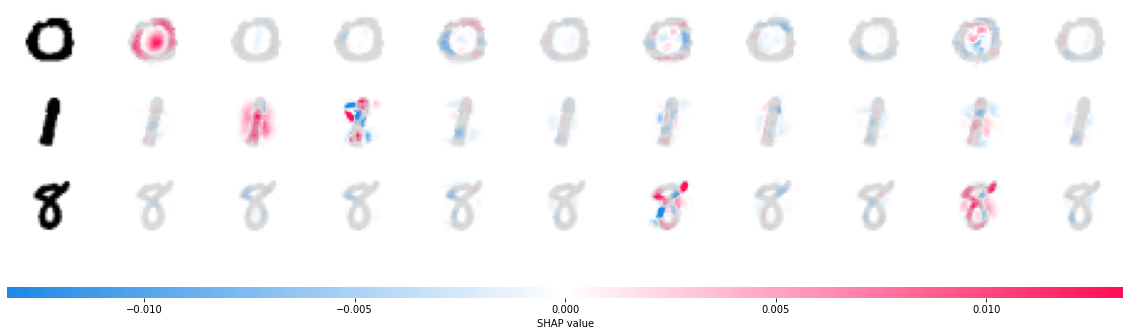

In [21]:
shap.image_plot(shap_numpy, -test_numpy)